# Recursive Feature Selection using Gradient based and Tree based Estimators 

In [1]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\users\anjal\anaconda3\lib\site-packages (0.7.0)
Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns

In [3]:
data = pd.read_csv('../data/profile_labelled.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.sample(10)

,gender,age,cust_id,became_member_on,days_as_member,income_in_k,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,customer_type
7277,M,81,6243a283a715407f8115809b5673390d,2018-06-23,892,38.0,0.0,2.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,13.84,10.000000,180.000000,0.0,12.0,1.00,0.000,2.31,0.006726,passive
7854,F,56,4c6523b95f094c258015c96a35e231b0,2016-08-08,1576,77.0,3.0,5.0,3.0,4.0,3.0,3.0,3.0,2.0,2.0,1.0,5.0,5.0,5.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,2.0,1.0,0.0,84.65,6.909091,137.454545,18.0,28.0,0.60,0.600,21.16,0.002538,active
2220,F,59,0020c2b971eb4e9188eac86d93036a77,2016-03-04,1733,90.0,3.0,5.0,3.0,8.0,3.0,3.0,3.0,3.0,1.0,2.0,5.0,5.0,5.0,3.0,2.0,2.0,1.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,196.86,8.181818,170.181818,14.0,24.0,0.60,0.600,24.61,0.004616,active
7134,M,68,8b113c0c1ccb4650ac550e3a7a7710f4,2016-01-23,1774,50.0,1.0,5.0,4.0,18.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0,4.0,4.0,4.0,3.0,2.0,0.0,4.0,4.0,4.0,3.0,3.0,1.0,0.0,43.88,10.100000,156.000000,3.0,38.0,0.80,0.200,2.44,0.010147,active
3235,F,45,591b17b5a24a44f7a23bd2296e46e0c4,2013-09-09,2640,82.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,2.0,2.0,2.0,0.0,2.0,1.0,3.0,2.0,2.0,2.0,0.0,2.0,1.0,69.33,8.714286,161.142857,3.0,8.0,1.00,0.333,23.11,0.001136,active
13068,F,19,23546fb2449845b6b5a09bd9d33e900c,2017-10-21,1137,58.0,1.0,2.0,2.0,5.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,75.61,6.000000,129.600000,2.0,2.0,1.00,0.500,15.12,0.004398,active
8807,F,62,63305b7efae44338a6d7c6c78c996a1e,2018-03-04,1003,51.0,0.0,6.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,5.0,5.0,2.0,3.0,1.0,6.0,3.0,5.0,5.0,2.0,3.0,1.0,15.57,8.666667,156.000000,0.0,25.0,1.00,0.000,7.78,0.001994,passive
1468,F,33,28b4168756ee40559f8d8a98762f28ab,2016-03-24,1713,71.0,4.0,6.0,5.0,13.0,4.0,3.0,3.0,3.0,3.0,1.0,6.0,3.0,5.0,5.0,3.0,1.0,2.0,5.0,3.0,5.0,4.0,3.0,0.0,2.0,192.14,7.666667,139.200000,30.0,30.0,0.83,0.667,14.78,0.007589,active
3495,M,42,1852fd4c322746798b6128917e068aa7,2014-01-02,2525,57.0,3.0,6.0,6.0,21.0,3.0,2.0,3.0,3.0,1.0,2.0,6.0,5.0,6.0,5.0,2.0,3.0,1.0,6.0,5.0,6.0,5.0,2.0,3.0,1.0,66.47,6.400000,172.800000,10.0,17.0,1.00,0.500,3.17,0.008317,active
3034,F,57,d0532474533d4dcaa552813f36898506,2016-03-07,1730,34.0,0.0,6.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,4.0,5.0,4.0,2.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,16.15,10.000000,168.000000,0.0,35.0,0.33,0.000,1.62,0.005780,passive


In [4]:
# define dataset
gen_split = pd.get_dummies(data['gender'], prefix='is_')
data = pd.concat([data, gen_split], axis=1)
data.drop('gender', axis=1, inplace=True)
data.sample(10)

,age,cust_id,became_member_on,days_as_member,income_in_k,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,customer_type,is__F,is__M,is__O
14269,76,62c2e5535e4045a480a52cf68ab72e3e,2017-09-27,1161,119.0,0.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,0.0,1.0,41.39,5.000000,120.000000,0.0,15.0,0.60,0.000,41.39,0.000861,passive,1,0,0
1515,26,6860d544db4d41debe162f7f89747f35,2013-09-30,2619,56.0,0.0,4.0,3.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,2.0,2.0,0.0,2.0,3.0,3.0,3.0,1.0,2.0,0.0,1.0,58.03,5.714286,116.571429,0.0,20.0,0.75,0.000,3.87,0.005727,passive,0,1,0
6239,100,be79870ff776461d97e1aee515269644,2017-11-26,1101,47.0,4.0,6.0,5.0,14.0,4.0,2.0,3.0,3.0,2.0,2.0,6.0,4.0,5.0,3.0,4.0,2.0,0.0,5.0,4.0,5.0,2.0,4.0,1.0,0.0,155.49,11.333333,168.000000,27.0,47.0,0.83,0.667,11.11,0.012716,active,1,0,0
9039,65,0a0bb27cb9904b638d376ad1c6d09e81,2016-09-28,1525,99.0,5.0,5.0,4.0,13.0,5.0,4.0,5.0,4.0,3.0,2.0,5.0,4.0,5.0,4.0,3.0,2.0,0.0,4.0,3.0,4.0,4.0,2.0,2.0,0.0,385.69,7.214286,173.142857,25.0,25.0,0.80,1.000,29.67,0.008525,active,1,0,0
1374,78,55b8653d0c614b5884b6da92d9e90c2a,2017-10-28,1130,72.0,2.0,6.0,6.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,6.0,3.0,5.0,6.0,3.0,3.0,0.0,6.0,3.0,5.0,6.0,3.0,3.0,0.0,34.80,10.357143,180.000000,7.0,34.0,1.00,0.333,17.40,0.001770,active,1,0,0
9558,73,df9111f3ee6e4031a6fb62e25b727c22,2016-09-09,1544,57.0,2.0,2.0,1.0,5.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,70.12,10.000000,168.000000,12.0,12.0,0.50,1.000,14.02,0.003238,passive,1,0,0
301,42,cda87c53c8434854b78be68c0cde4848,2017-09-08,1180,75.0,2.0,5.0,5.0,6.0,2.0,2.0,2.0,2.0,1.0,1.0,5.0,2.0,5.0,5.0,1.0,1.0,3.0,5.0,2.0,5.0,5.0,1.0,1.0,3.0,148.84,3.000000,120.000000,8.0,8.0,1.00,0.400,24.81,0.005085,active,0,1,0
1654,62,a4d629a11c0746c69c01f660286dea7e,2017-12-14,1083,72.0,3.0,6.0,6.0,5.0,3.0,1.0,3.0,3.0,2.0,1.0,6.0,1.0,5.0,6.0,2.0,3.0,1.0,6.0,1.0,5.0,6.0,2.0,3.0,1.0,92.17,7.400000,168.000000,13.0,20.0,1.00,0.500,18.43,0.004617,active,1,0,0
6769,61,d52fefcf60764f96bf6e9cfa6d425a22,2017-04-23,1318,75.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,0.0,6.0,5.0,6.0,4.0,5.0,0.0,1.0,4.0,4.0,4.0,2.0,3.0,0.0,1.0,96.64,6.538462,127.384615,25.0,35.0,0.67,0.500,24.16,0.003035,active,1,0,0
3413,66,1502fe1c8f9c4973bc0631d34f5147bf,2016-11-20,1472,103.0,1.0,3.0,1.0,6.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,2.0,3.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,158.35,8.000000,153.600000,5.0,5.0,0.33,0.333,26.39,0.004076,passive,0,1,0


## Finding set of correlated features

In [5]:
correlated_features = set()
correlation_matrix = data[['is__F', 'is__M', 'is__O', 'age', 'income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
correlated_features

{'is__M'}

## Adding label

In [6]:
data['customer_type'] = "passive"
data.loc[(data['total_view_ratio'] >= 0.6) & (data['total_completion_ratio'] >= 0.2), 'customer_type'] = "active" 
data['customer_type'].value_counts()

active     9637
passive    5188
Name: customer_type, dtype: int64

## Set X as Input features and y as target label

In [7]:
X = data[['is__F','is__M', 'is__O', 'age', 'income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']]
y = data['customer_type']


## Split Data to Training and Testing Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [9]:
#Print the shape of training and test data
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (11118, 10)
X_test:  (3707, 10)


## Running RFECV

In [10]:
#RFECV automatically selects the number of features
#Checking with Random Forest Classifier model
model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])

pipeline.fit(X_train, y_train)

print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Feature selection array: ', rfecv.support_)
print('Feature Ranking: ',rfecv.ranking_)

Optimal number of features: 6
Feature selection array:  [False False False False  True  True  True  True  True  True]
Feature Ranking:  [3 4 5 2 1 1 1 1 1 1]


In [11]:
#evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('F1 Score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

F1 Score: 0.717 (0.011)


## Plotting the RFECV curve for the model with best accuracy

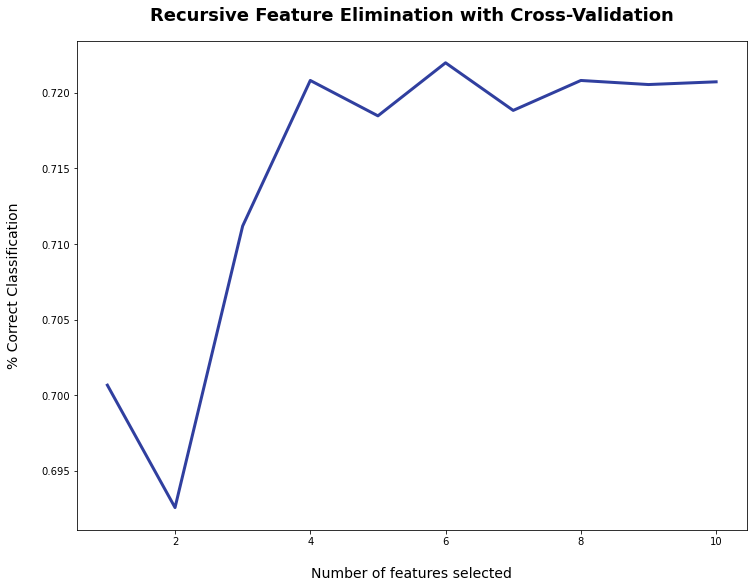

In [12]:
plt.figure(figsize=(12, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [13]:
# Least important features

print(np.where(rfecv.support_ == False)[0])

#Dropping the non-required features from training and test data
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[0 1 2 3]


In [14]:
#Print features and feature importance
print("Features: ", X_train.columns)
print("Feature Importance: ", rfecv.estimator_.feature_importances_)

Features:  Index(['income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt',
       'transactions_per_membership_days', 'days_as_member'],
      dtype='object')
Feature Importance:  [0.09056958 0.12304832 0.11080375 0.33686662 0.21147273 0.12723901]


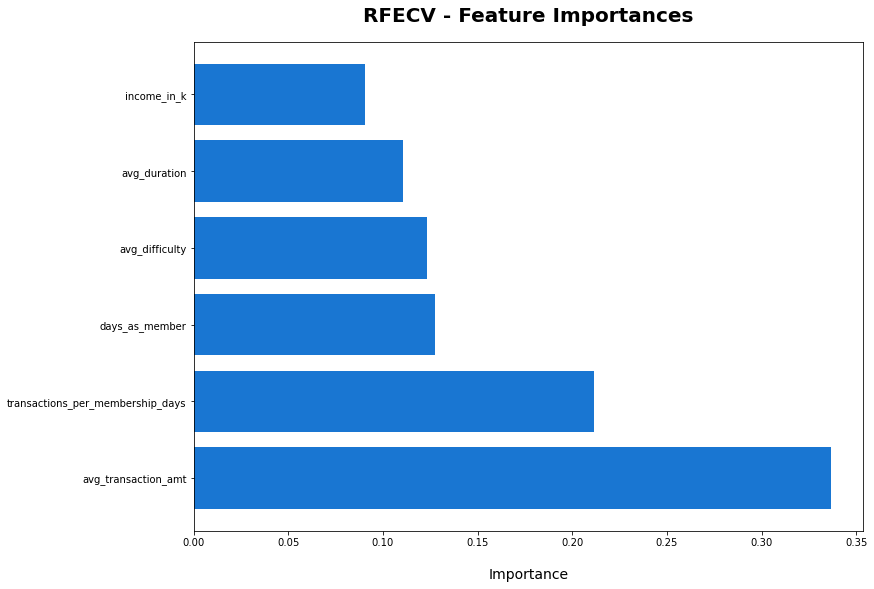

In [15]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(12, 9))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Check if data is balanced

In [16]:
y_train.value_counts()

active     7240
passive    3878
Name: customer_type, dtype: int64

In [17]:
#Find percentage distribution
round((y_train.value_counts()/y_train.count())*100,2)

active     65.12
passive    34.88
Name: customer_type, dtype: float64

#### The target classes are imbalanced!

### SMOTE

In [18]:
#Applying SMOTE to oversample the minority class before modeling
oversample = SMOTE(random_state = 101)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [19]:
#check percentage distribution
round((y_train.value_counts()/y_train.count())*100,2)

passive    50.0
active     50.0
Name: customer_type, dtype: float64

In [20]:
y_train.value_counts()

passive    7240
active     7240
Name: customer_type, dtype: int64

In [21]:
#Changing active to 1 and passive to 0 to get f1 score
#Training data
y_train = y_train.replace(to_replace='active', value= 1)
y_train = y_train.replace(to_replace='passive', value= 0)

#Testing data
y_test = y_test.replace(to_replace='active', value= 1)
y_test = y_test.replace(to_replace='passive', value= 0)

In [22]:
y_train

0        1
1        0
2        1
3        1
4        0
        ..
14475    0
14476    0
14477    0
14478    0
14479    0
Name: customer_type, Length: 14480, dtype: int64

## Modeling and Prediction

In [23]:
#Use GridSearchCV to fit selected classifiers to compare the efficiencies of different models
def train_classifier(classifier, hyperparameters, X, y): 
    gridsearch = GridSearchCV(estimator=classifier, param_grid = hyperparameters, cv=5, verbose=1, scoring = 'f1')
    model_train = gridsearch.fit(X, y)
    print(classifier.__class__.__name__)
    print("Mean Accuracy:", round(model_train.score(X, y),4))
    print("F1: ",gridsearch.best_score_)
    return gridsearch.best_estimator_

In [24]:
# Initialize classification algorithms
# LogisticRegression
lor = LogisticRegression(random_state=42)
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=42) 
# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=42) 
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42) 

classification_algs = [lor,rfc,abc,gbc]
classifier_dict={}

for classifier in classification_algs:
    #training with no hyperparameters
    best_est = train_classifier(classifier,{}, X_train, y_train)
    #classifier_dict[classifier] = best_est

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression
Mean Accuracy: 0.7091
F1:  0.7193629237740148
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s finished


RandomForestClassifier
Mean Accuracy: 1.0
F1:  0.8157895075036375
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


AdaBoostClassifier
Mean Accuracy: 0.7743
F1:  0.7668186944532038
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s finished


GradientBoostingClassifier
Mean Accuracy: 0.8018
F1:  0.7854419462978168


#### Highest f1 score is obtained for Gradient Boosting Classifier

## Fine Tuning the Model

In [25]:
#Tuning the RandomForestClassifier with hyperparameters to improve the accuracy score
hyperparameters = {'n_estimators': [120],#[100, 120, 300, 500, 800, 1200], #sets the number of decision trees to be used in the forest
                  'max_depth': [8],#[5, 8, 15, 25, 30, None], #sets the max depth of the tree
                  'min_samples_split': [2],#[1,2,5,10,15,100], #The minimum number of samples needed before a split
                  'min_samples_leaf': [1]#[1,2,5,10], #The minimum number of samples needed to create a leaf (decision) node
             }

rfc = RandomForestClassifier(random_state=42)
rfc_best_est = train_classifier(rfc, hyperparameters, X_train, y_train)
print(rfc_best_est)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished


RandomForestClassifier
Mean Accuracy: 0.822
F1:  0.7914105998905214
RandomForestClassifier(max_depth=8, n_estimators=120, random_state=42)


In [26]:
#Feature importances given by the best estimate RandomForestClassfier
rfc_best_est.feature_importances_

array([0.08284729, 0.04684257, 0.04930609, 0.45652127, 0.24316397,
       0.12131882])

In [27]:
#Tuning the GradientBoostingClassifier with hyperparameters to improve the accuracy score
#learning_rate; default=0.1; shrinks the contribution of each tree by learning_rates
lr = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

#n_estimators, default=100, number of boosting stages to perform
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#max_depth, default=3, maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree
max_depths = np.linspace(1, 32, 32, endpoint=True)

#min_samples_split, default=2, The minimum number of samples required to split an internal node
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)

#min_samples_leaf, default=1,The minimum number of samples required to be at a leaf node.
min_samples_leaf=np.linspace(0.1, 0.5, 5, endpoint=True)

#max_features{‘auto’, ‘sqrt’, ‘log2’}, default=None, The number of features to consider when looking for the best split:
max_features = list(range(1,X_train.shape[1]))

gb_tuned = GradientBoostingClassifier(random_state=42)
hyperparameters = {'learning_rate': [0.5], 'n_estimators': [200]}#, 'max_depth': max_depths}#, 'min_samples_split': min_samples_split, 'min_samples_leaf':min_samples_leaf, 'max_features':max_features}   
gb_best_est = train_classifier(gb_tuned, hyperparameters, X_train, y_train)
print(gb_best_est)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.4s finished


GradientBoostingClassifier
Mean Accuracy: 0.8933
F1:  0.8063378502408709
GradientBoostingClassifier(learning_rate=0.5, n_estimators=200, random_state=42)


## Predict

In [28]:
#Print the shape of test data
print(X_test.shape)
print(y_test.shape)

(3707, 6)
(3707,)


In [29]:
#Passing the test data to the GradientBoodtingClassifier estimator
y_pred = gb_best_est.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

## Measuring Performance of Classification

### Confusion Matrix 

In [30]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[ 901,  409],
       [ 324, 2073]], dtype=int64)

In [31]:
#Get True Negative tn, False Positive FP, False Negative FN, True Positive values from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('(tn, fp, fn, tp) : ', (tn, fp, fn, tp))

(tn, fp, fn, tp) :  (901, 409, 324, 2073)


In [34]:
#f1 score of predicted data
f1_score = f1_score(y_test, y_pred)
print('F1 score of Model Prediction: ', f1_score)

F1 score of Model Prediction:  0.8497642959622873


### The F1 score of predicted results, the model on test data is better at 84.97%

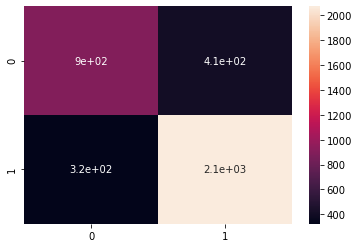

In [37]:
#Plot the confusion Matrix
sns.heatmap(cf_matrix, annot=True)

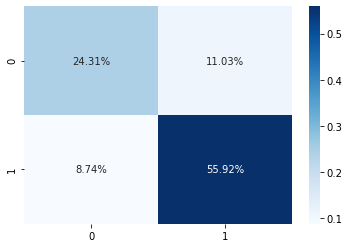

In [38]:
#Confusion Matrix plotted with Percentage values
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')